# Lab 6 - CNNs
#### Liam Lowsley-Williams, Fernando Vázquez


## Introduction

For this lab, we chose to use an image based dataset for road sign classification from Traffic Signs Preprocessed dataset. We used a data set that consisted of 86989 of images across 43 different classifications of traffic signs. The traffic signs included but were not limited to speed signs, stop signs, children crossing signs, and etc. Our primary interest is to classify a particular sign (such as speed) accurately for updating navigation apps to include speed data. We are also interested in beginning to explore the possibilities of real-time autodetection of these signs for autonomous driving.

Link to Dataset: https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed

## Business Case

### Motivation

The drive for automation is stronger now than it ever has been before. We have expanded to automate not only industrial applications but now our own households and everyday environments too. From smart homes to driving, the innovations are endless and usually very beneficial. The area we are focusing on in this lab is automation when it comes to driving and driving utilities. Many navigation apps today such as Waze or Google Maps now include speed data directly in the app for many popular roads around the world. The idea behind our use case is to develop a neural network that shows promising ability to classify these signs and use it to update map speed data via user’s iphones. This would allow Google to collect sign data information from users on millions of roads across the U.S. that could be used for updating their app to provide useful and up to date information.

The other motivation here is to begin exploring the possibility of developing an autonomous detection system for speed signs to self regulate autonomous vehicles. This could prove to be immensely useful in the rapidly-expanding industry of self-driving cars. Using existing DOT data on road information along with real time detection could seriously improve the safety and performance of self-driving cars on the road. 

### Objective

Our objective in this lab is to construct a neural network that is capable of classifying road signs correctly. We will be using accuracy as our metric (discussed later) and given our application is related to driving motor vehicles on government roads, our model must be extremely accurate as a mis-classification could be extremely dangerous. However, the measure of accuracy does not have to reflect all classes. It could be focused on a subset group such as speed sign classification. That being said, the metric must still perform extremely well regardless of the subset. We are aiming to reach a performance of above at least 90% to satisfy the map navigation use case and a near perfect score for consideration of using such a model for real time detection.

### Evaluation

Our business case calls for being able to accurately classify road signs in real world and real time scenarios for possible use in autonomous vehicles. With the rise of autonomous driving, errors must be minimized in order to mitigate monetary loss or loss of life. Since our dataset is made up of road signs which is a very fundamental part of driving, we need to be positive that correct classification occurs. We have decided to use accuracy as our metric because we need to give each class the same amount importance. Accuracy is determined by taking the number of correct predictions and dividing it by the total amount of predictions. We also chose to use accuracy since our data has the same amount of instances for each class therefore bias isn’t given to any one class.

$$Accuracy=\frac{Correct Predictions}{Total Predictions}$$

### Data Prep Explanation

Our Dataset consists of 86989 images from the Traffic Signs Preprocessed dataset. The dataset has already gone through a round of preprocessing in that the classes have been equalized by adding images to the classes that were rotations or changes of lighting from the images that were already present. After that preprocessing the Kaggle dataset created multiple pickle files that had varying amounts of normalization applied to them we decided to use data3.pickle. The pickle file was also organized to have seperate train, test and validation sets and we went ahead and just used those. We decided to use the premade ones because the sizes of the set were 86989 for the train and 12000 for the test. This is enough data to use for a 80/20 split.

## Function & Package Intialization
#### DONT FORGET TO SWITCH KERNEL TO GPU!!!

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.0.0
Default GPU Device: /device:GPU:0


In [31]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, roc_curve, auc

from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import pickle
import numpy as np

# graph visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.__version__

'2.3.1'

In [3]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

def cnn_heatmap(cnn, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))

## Data Processing

### TRAFFIC PREPROCESS

In [85]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=4, n_col=8):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=32)
    n = 0
    for i in rand_sample:
        plt.subplot(n_row, n_col, n + 1)
 #       plt.imshow(images[i].astype('uint8'))
        plt.imshow(np.transpose(images[i], (2, 1, 0)), interpolation='nearest')
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())
        n = n+1

### Loading in data from premade Pickle files

In [12]:
file = open("./data/traffic/data0.pickle", "rb")
data = pickle.load(file) 

In [13]:
X_train_tr = data['x_train']
X_test_tr = data['x_test']
y_train_tr = data['y_train']
y_test_tr = data['y_test']

In [69]:
np.transpose(X_train_tr[500], (1, 2, 0)).shape

(32, 32, 3)

### Visualizing some of the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


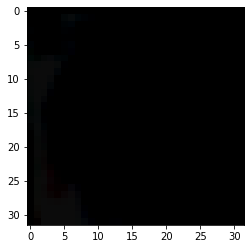

In [101]:
#plt.imshow(, interpolation='nearest')

# x=np.transpose(X_train_tr[500], (2, 1, 0))

# plt.imshow(x,interpolation='nearest')
plt.imshow(np.transpose(X_train_tr[500], (2, 1, 0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

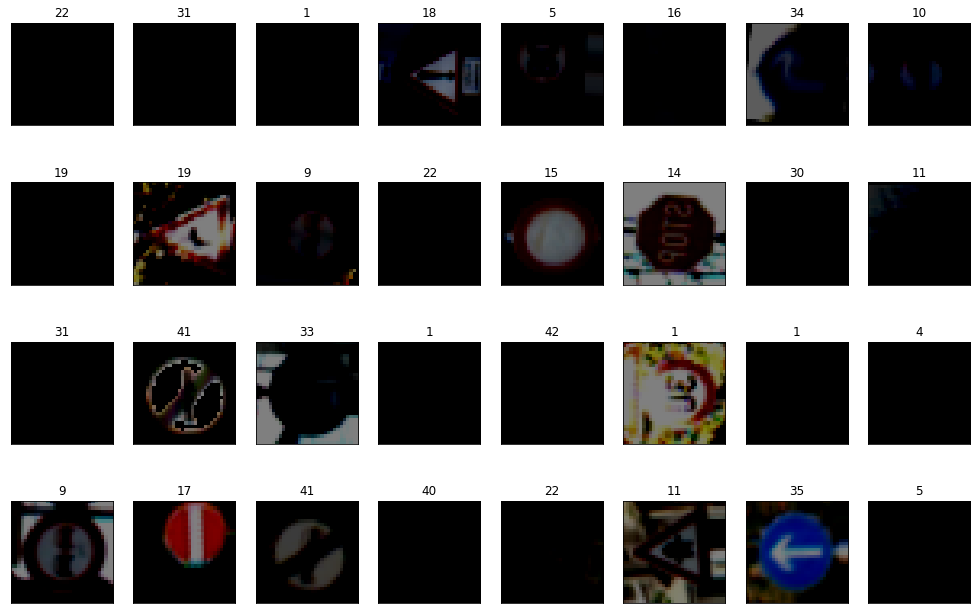

In [90]:
plot_gallery(X_train_tr, y_train_tr,32,32)

In [64]:
X_train_tr.shape

(96989, 3, 32, 32)

In [65]:
X_train_tr[0].shape

(3, 32, 32)

### Data Expansion
For Data Expansion we decided to mainly rotate the images using an ImageDataGenerator because in the real world signs may have moved due to their exposure to the elements. We have also decided to use 10000 expanded images in order to increase our training dataset'|

In [24]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=8, # used, Int. Degree range for random rotations.
    width_shift_range=0.2, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.2, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    data_format='channels_first',
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train_tr)

In [25]:
tmps = datagen.flow(X_train_tr, y_train_tr, batch_size=1)
count=0
xdata=[]
ydata=[]
for tmp in tmps:
    #tt=np.transpose(tmp[0].squeeze(), (1, 2, 0))
    tt=tmp[0].squeeze()
    tt=tt.astype('uint8')
    xdata.append(tt)
    ydata.append(tmp[1][0])
    #print(tt.shape)
    #plt.imshow(out.astype('uint8'))
    #print(tt)
    #print(tmp[1][0])
    #imshow(tt,cmap='bone')
    
    #plt.title(classes[np.argmax(tmp[1])])
    count+=1
    if count==10000:
        break
        
xdata=np.asarray(xdata, dtype=np.float32)
ydata=np.array(ydata)
# print("xdata shape: ",xdata.shape)
# print("ydata shape: ",ydata.shape)
# ydata[0]

print("X_train_tr shape: ",X_train_tr.shape)
print("y_train_tr shape: ",y_train_tr.shape)

X_train_tr = np.append(X_train_tr, xdata, axis=0)
y_train_tr = np.append(y_train_tr, ydata)

print("\nOnce expanded data is added")
print("X_train_tr shape: ",X_train_tr.shape)
print("y_train_tr shape: ",y_train_tr.shape)

X_train_tr shape:  (86989, 3, 32, 32)
y_train_tr shape:  (86989,)

Once expanded data is added
X_train_tr shape:  (96989, 3, 32, 32)
y_train_tr shape:  (96989,)


In [26]:
#Some data Normalization
X_train_tr = X_train_tr/255 - .5
X_test_tr = X_test_tr/255 - .5

In [27]:
y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

## Modeling

### Architecture 1 - Param Set 1

INIT ARCHITECTURE
 - filter layers 24 -> 24
 - kernel size 3x3
 - pool size 2x2
 - dense layers 100 -> 100

In [28]:
%%time
'''
INIT ARCHITECTURE
'''
img_sz = 32 # width and height of img

cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                     kernel_size=(3,3), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(43, activation='softmax') )

cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

Wall time: 1.83 s


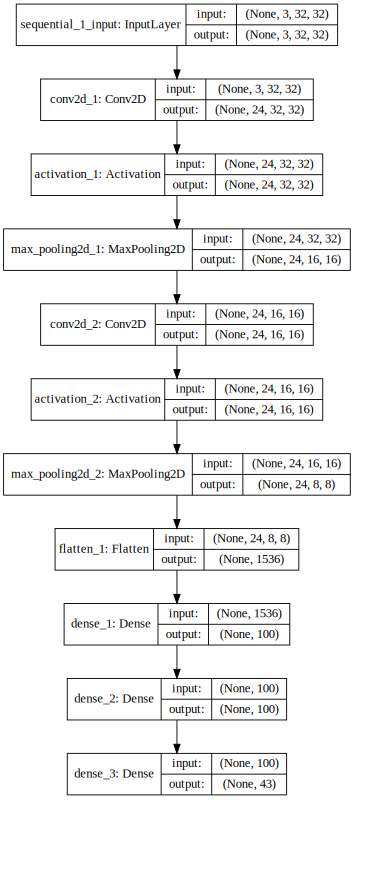

In [102]:
SVG(model_to_dot(cnn1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [33]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn1_hist = cnn1.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 96989 samples, validate on 12630 samples
Epoch 1/15
96989/96989 [==============================] - 22s 231us/step - loss: 0.0015 - accuracy: 0.9528 - val_loss: 0.0032 - val_accuracy: 0.9162
Epoch 2/15
96989/96989 [==============================] - 20s 202us/step - loss: 0.0015 - accuracy: 0.9538 - val_loss: 0.0031 - val_accuracy: 0.9204
Epoch 3/15
96989/96989 [==============================] - 18s 186us/step - loss: 0.0015 - accuracy: 0.9561 - val_loss: 0.0033 - val_accuracy: 0.9136
Epoch 4/15
96989/96989 [==============================] - 18s 180us/step - loss: 0.0014 - accuracy: 0.9579 - val_loss: 0.0035 - val_accuracy: 0.9116
Wall time: 1min 17s


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Text(0.5, 0, 'epochs')

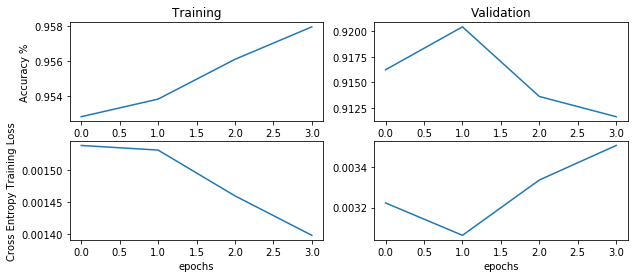

In [35]:
print(cnn1_hist.history.keys())
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn1_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn1_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn1_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn1_hist.history['val_loss'])
plt.xlabel('epochs')

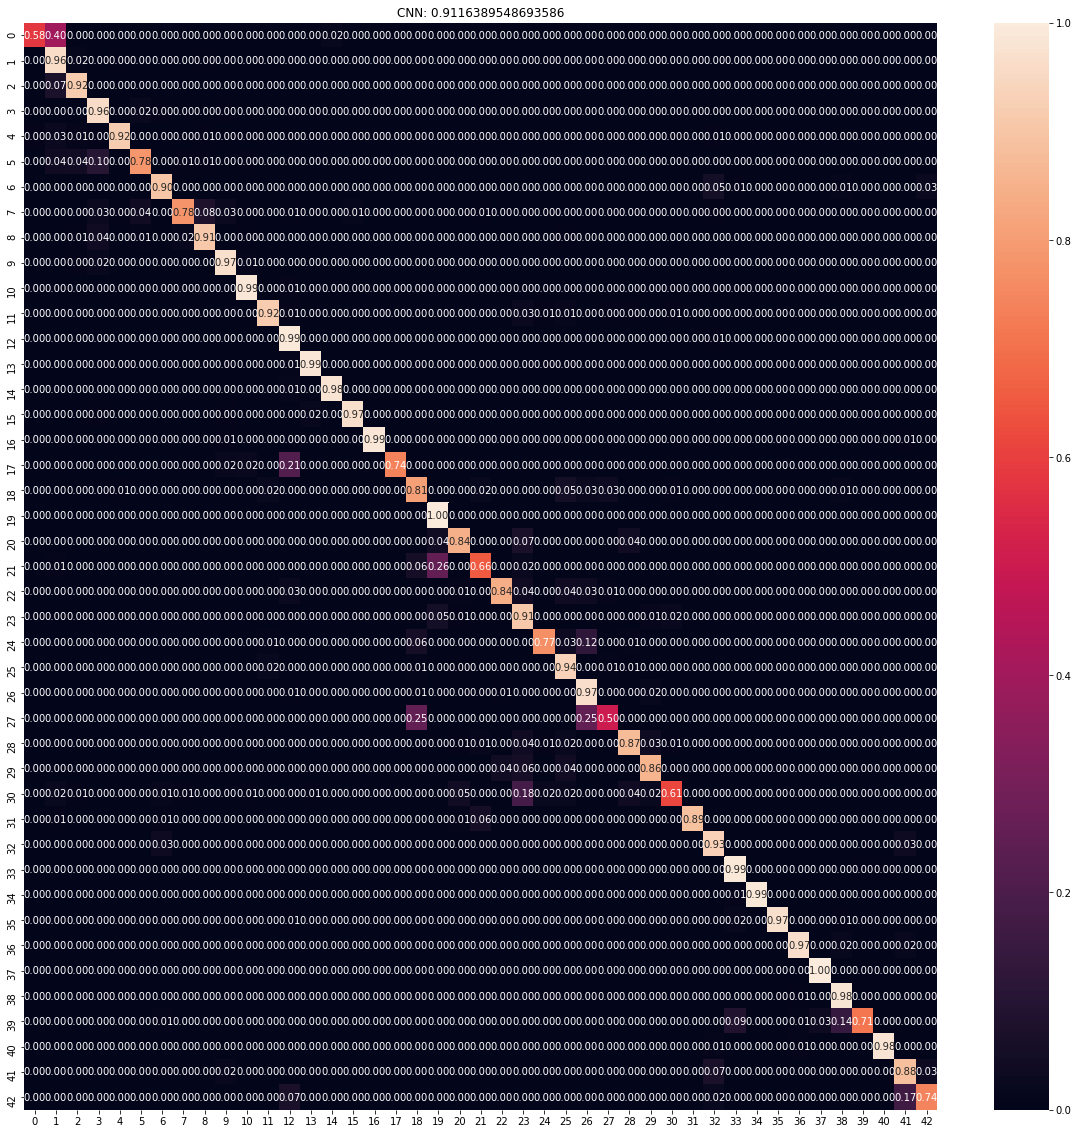

In [36]:
cnn_heatmap(cnn1,X_test_tr,y_test_tr)

As seen above, our first model performs quite well on the train and test data. There may be a bit of evidence suggesting overtraining here as the validation begins to degrade with further epochs. That being said, the model performs to the expectations we initially set forth for the maps application, there would need to be some more improvement before considering it for autonomous driving. 

### Architecture 1 - Param Set 2

arch 1 param 2:
CHANGES:
 - filter size 24 -> 48
 - kernel size 4x4
 - CHANGED THE ACTIVATION FUNCTION IN THE 2 DENSE LAYERS TO LINEAR

In [37]:
%%time
'''
CHANGES:
 - DOUBLED SIZE OF SECOND FILTER LAYER
 - INCREASED SIZE OF KERNEL TO (4,4)
 - CHANGED THE ACTIVATION FUNCTION IN THE 2 DENSE LAYERS TO LINEAR
'''

img_sz = 32 # width and height of img

cnn2 = Sequential()
num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                     kernel_size=(4,4), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn2.add( Activation('relu'))
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    
cnn2.add( Flatten() )
cnn2.add( Dense(100, activation='linear') )
cnn2.add( Dense(100, activation='linear') )
cnn2.add( Dense(43, activation='softmax') )

cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

Wall time: 14 ms


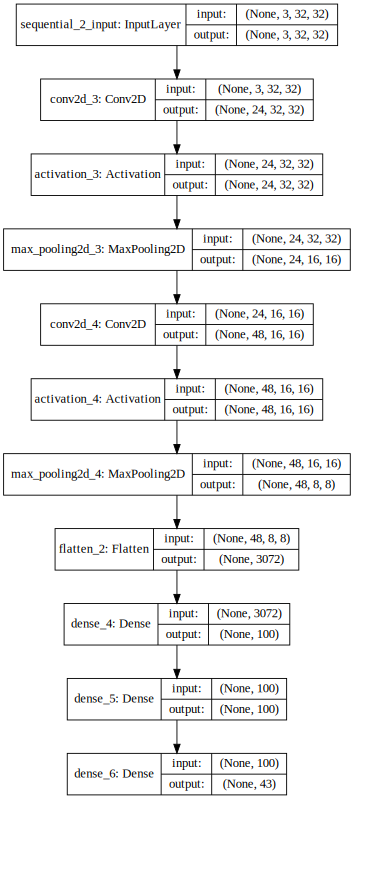

In [91]:
SVG(model_to_dot(cnn2, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [41]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn2_hist = cnn2.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )



Train on 96989 samples, validate on 12630 samples
Epoch 1/15
96989/96989 [==============================] - 23s 234us/step - loss: 0.0037 - accuracy: 0.8928 - val_loss: 0.0029 - val_accuracy: 0.9158
Epoch 2/15
96989/96989 [==============================] - 22s 231us/step - loss: 0.0031 - accuracy: 0.9121 - val_loss: 0.0028 - val_accuracy: 0.9229
Epoch 3/15
96989/96989 [==============================] - 22s 226us/step - loss: 0.0028 - accuracy: 0.9205 - val_loss: 0.0027 - val_accuracy: 0.9236
Epoch 4/15
96989/96989 [==============================] - 23s 233us/step - loss: 0.0026 - accuracy: 0.9279 - val_loss: 0.0028 - val_accuracy: 0.9230
Epoch 5/15
96989/96989 [==============================] - 23s 239us/step - loss: 0.0024 - accuracy: 0.9321 - val_loss: 0.0025 - val_accuracy: 0.9314
Epoch 6/15
96989/96989 [==============================] - 22s 230us/step - loss: 0.0024 - accuracy: 0.9349 - val_loss: 0.0031 - val_accuracy: 0.9188
Epoch 7/15
96989/96989 [==============================] 

Text(0.5, 0, 'epochs')

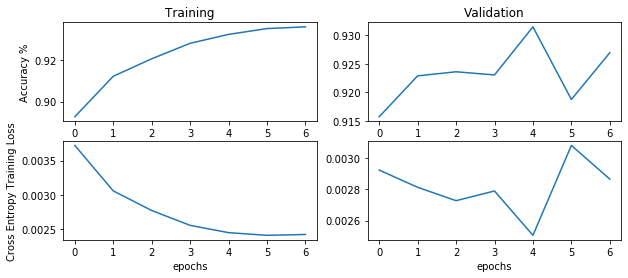

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn2_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn2_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn2_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn2_hist.history['val_loss'])
plt.xlabel('epochs')

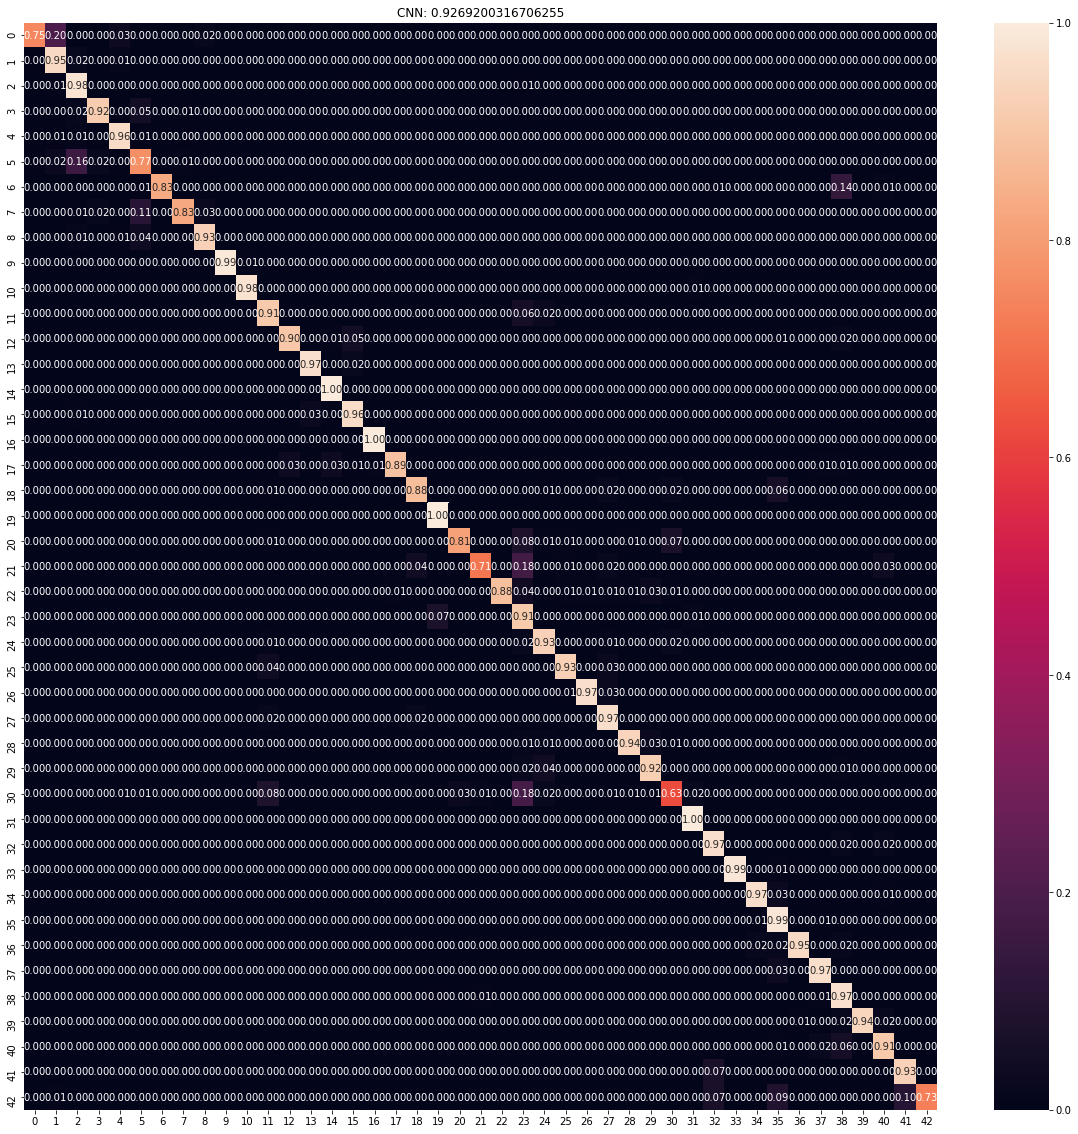

In [44]:
cnn_heatmap(cnn2,X_test_tr,y_test_tr)

As seen above, our second model performs better than the first. After changes we see a higher peak validation accuracy however there still may be a bit of evidence suggesting overtraining in further epochs. That being said, the model still performs to the expectations and exceeds that of the first model. However, there would still need to be some more improvement before considering it for autonomous driving.

### Architecture 2 - Param Set 1

arch 2 param 1:
INIT ARCHCITECTURE
 - filter layers 24 -> 48 -> 96 -> 128
 - kernel size 4x4 -> 3x3
 - pool size 2x2 -> 2x2
 - dense layers 100 -> 100 -> 50

In [92]:
%%time
'''
INIT ARCHCITECTURE
'''
img_sz = 32 # width and height of img

cnn3 = Sequential()
num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                     kernel_size=(4,4), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )

num_filt_layers = [96, 128]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                     kernel_size=(3,3), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )

cnn3.add( Flatten() )
cnn3.add( Dense(100, activation='linear') )
cnn3.add( Dense(100, activation='linear') )
cnn3.add( Dense(50, activation='linear') )
cnn3.add( Dense(43, activation='softmax') )

cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

Wall time: 202 ms


In [99]:
SVG(model_to_dot(cnn3, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [51]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn3_hist = cnn3.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
        )



Train on 96989 samples, validate on 12630 samples
Epoch 1/15
96989/96989 [==============================] - 25s 257us/step - loss: 0.0092 - accuracy: 0.6772 - val_loss: 0.0035 - val_accuracy: 0.8976
Epoch 2/15
96989/96989 [==============================] - 24s 245us/step - loss: 0.0033 - accuracy: 0.9019 - val_loss: 0.0032 - val_accuracy: 0.9185
Epoch 3/15
96989/96989 [==============================] - 25s 253us/step - loss: 0.0029 - accuracy: 0.9189 - val_loss: 0.0039 - val_accuracy: 0.9029
Epoch 4/15
96989/96989 [==============================] - 24s 251us/step - loss: 0.0030 - accuracy: 0.9213 - val_loss: 0.0040 - val_accuracy: 0.9022
Epoch 5/15
96989/96989 [==============================] - 25s 258us/step - loss: 0.0033 - accuracy: 0.9179 - val_loss: 0.0045 - val_accuracy: 0.8950
Epoch 6/15
96989/96989 [==============================] - 24s 253us/step - loss: 0.0037 - accuracy: 0.9117 - val_loss: 0.0040 - val_accuracy: 0.9086
Wall time: 2min 27s


Text(0.5, 0, 'epochs')

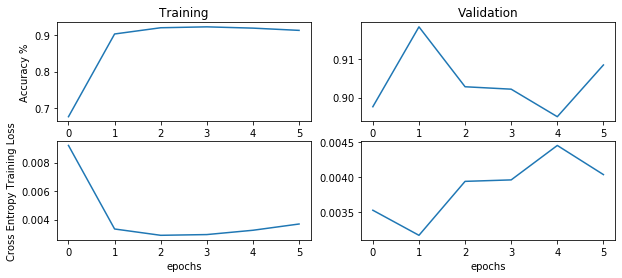

In [52]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn3_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn3_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn3_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn3_hist.history['val_loss'])
plt.xlabel('epochs')

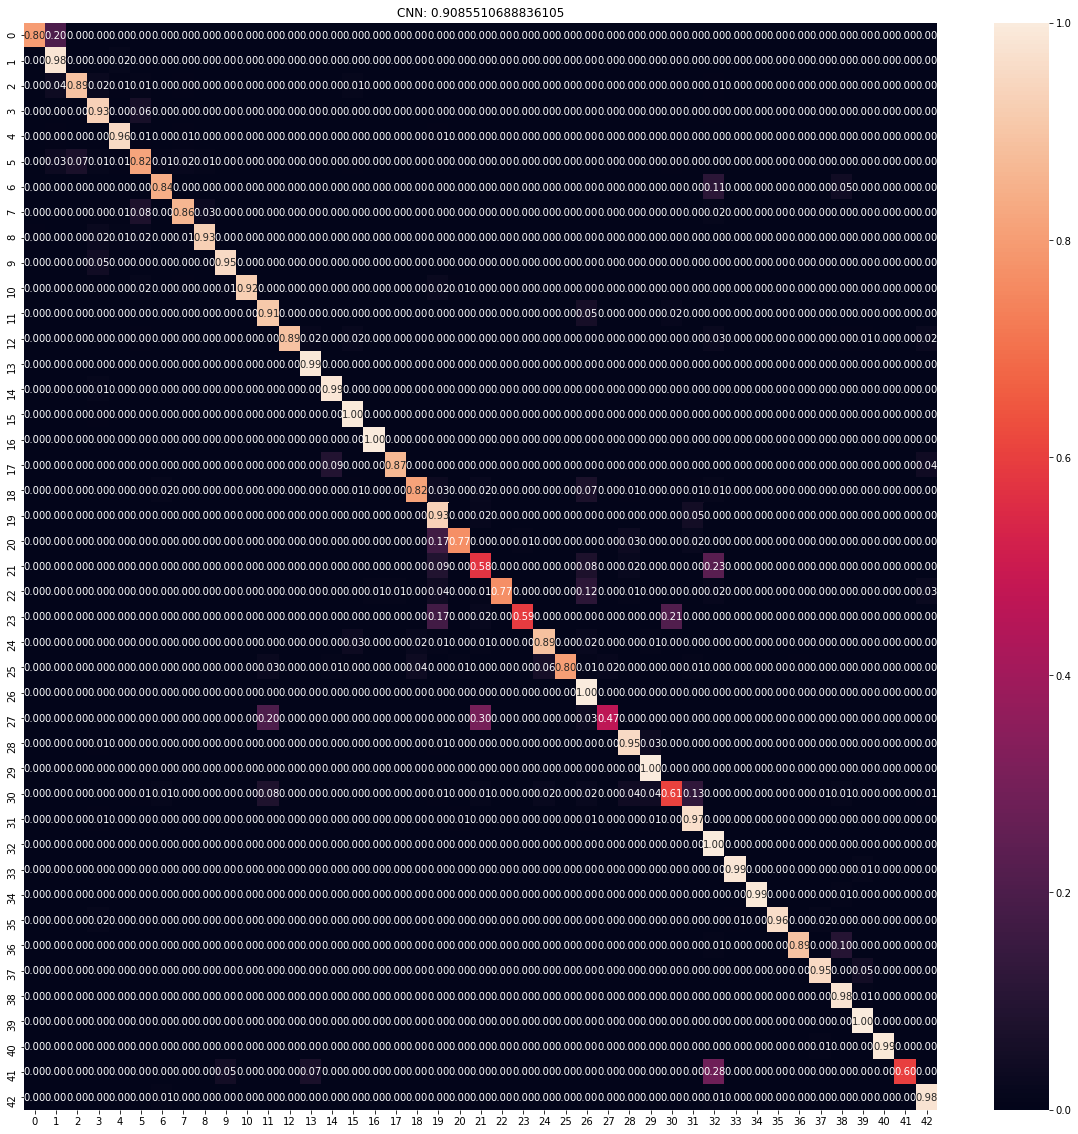

In [53]:
cnn_heatmap(cnn3,X_test_tr,y_test_tr)

As seen above, our third model doesnt perform as well as the first. After changes we see a higher peak validation accuracy however there still may be a bit of evidence suggesting overtraining in further epochs. That being said, the model still performs to the expectations but does not exceed the performance of the second model. However, there would still need to be some more improvement before considering it for autonomous driving.

### Architecture 2 - Param Set 2

arch 2 param 2:
CHANGES:
 - changed first 2 filter layers to 48 and 48 and second 2 filter layers to 96 and 96 in size
 - changed dense layers to 150 -> 100 -> 50

In [54]:
'''
INIT ARCHCITECTURE
'''
img_sz = 32 # width and height of img

cnn4 = Sequential()
num_filt_layers = [48, 48]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                     kernel_size=(4,4), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )

num_filt_layers = [96, 96]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                     kernel_size=(3,3), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )

cnn4.add( Flatten() )
cnn4.add( Dense(150, activation='linear') )
cnn4.add( Dense(100, activation='linear') )
cnn4.add( Dense(50, activation='linear') )
cnn4.add( Dense(43, activation='softmax') )

cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

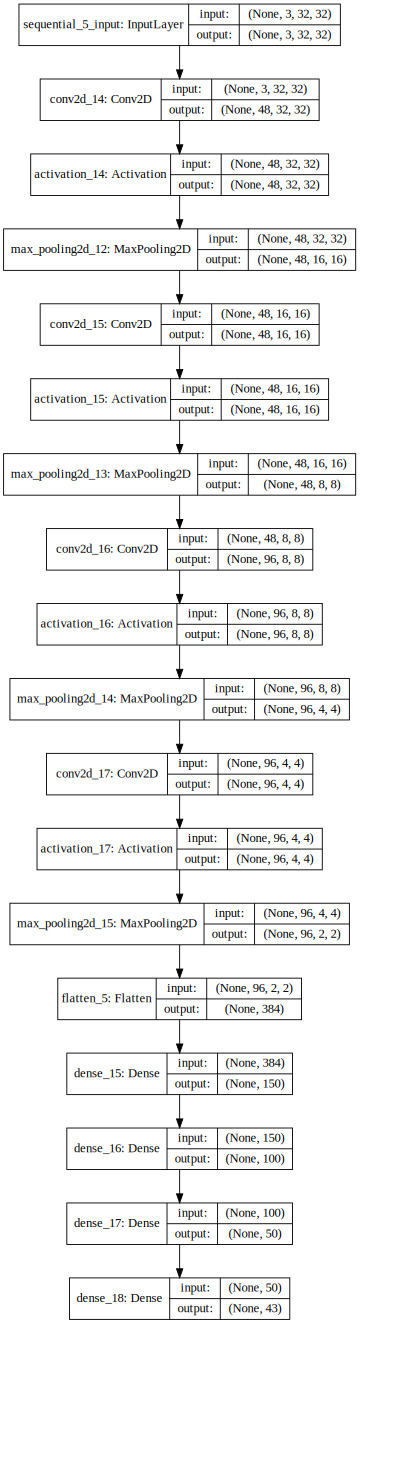

In [100]:
SVG(model_to_dot(cnn4, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [56]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn4_hist = cnn4.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )


Train on 96989 samples, validate on 12630 samples
Epoch 1/15
96989/96989 [==============================] - 27s 276us/step - loss: 0.0090 - accuracy: 0.6853 - val_loss: 0.0041 - val_accuracy: 0.8778
Epoch 2/15
96989/96989 [==============================] - 27s 281us/step - loss: 0.0034 - accuracy: 0.9005 - val_loss: 0.0039 - val_accuracy: 0.8957
Epoch 3/15
96989/96989 [==============================] - 27s 275us/step - loss: 0.0029 - accuracy: 0.9186 - val_loss: 0.0030 - val_accuracy: 0.9241
Epoch 4/15
96989/96989 [==============================] - 27s 279us/step - loss: 0.0028 - accuracy: 0.9244 - val_loss: 0.0031 - val_accuracy: 0.9199
Epoch 5/15
96989/96989 [==============================] - 26s 271us/step - loss: 0.0029 - accuracy: 0.9246 - val_loss: 0.0032 - val_accuracy: 0.9230
Wall time: 2min 15s


Text(0.5, 0, 'epochs')

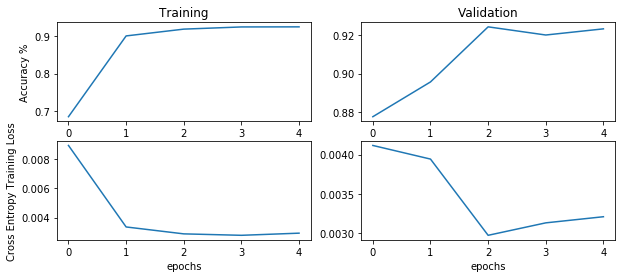

In [57]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn4_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn4_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn4_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn4_hist.history['val_loss'])
plt.xlabel('epochs')

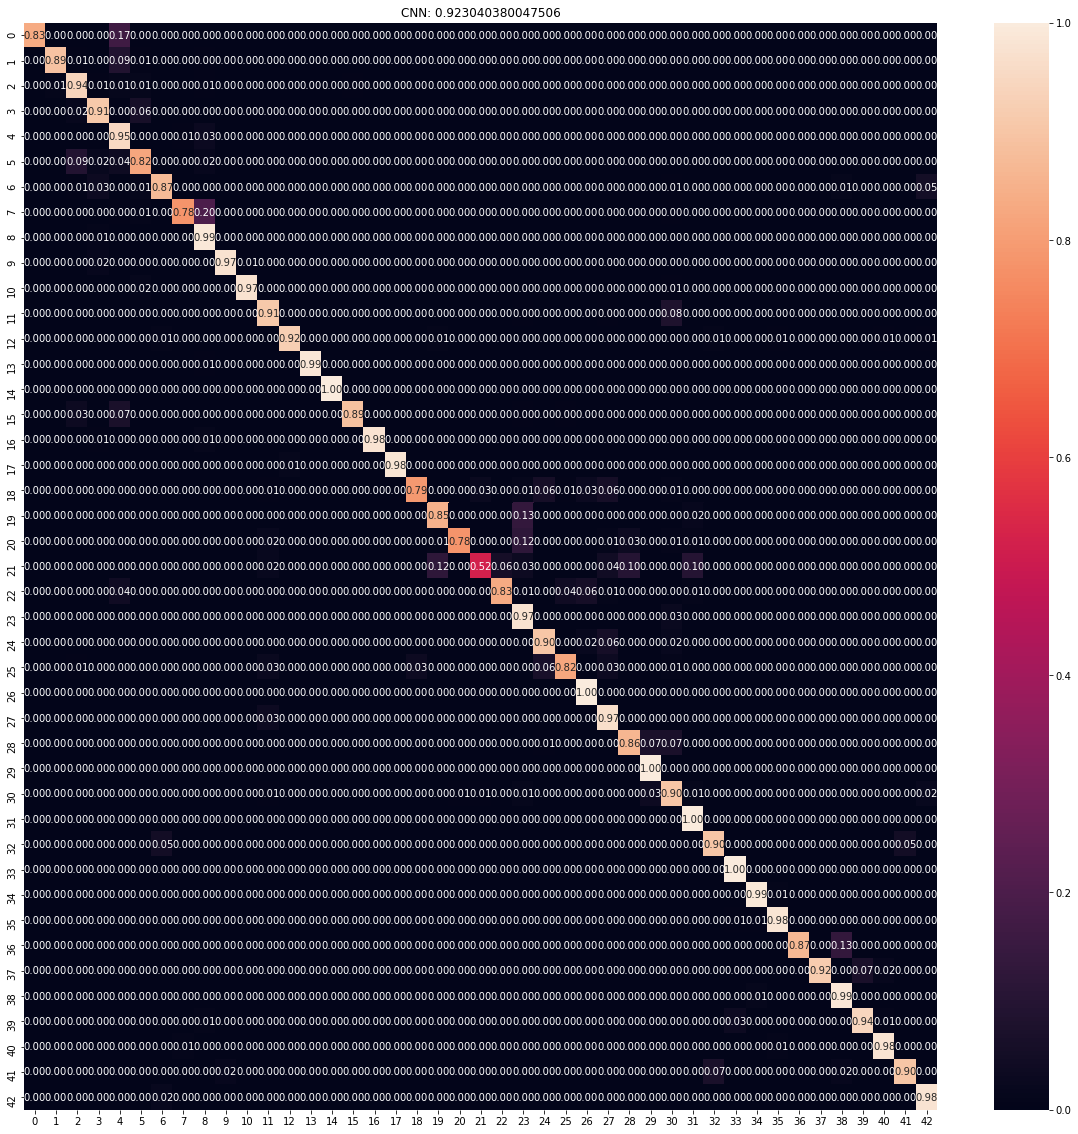

In [58]:
cnn_heatmap(cnn4,X_test_tr,y_test_tr)

For our last model we see that it performed almost as well as the second model and it met our expectations that we were trying to reach. There is some evidence of overfitting in the later epochs but the architecture worked well.

### Comparison of all CNNs

### MLP Comparison

In [59]:
%%time

y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add(Flatten())
mlp.add( Dense(input_dim=X_train_tr.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(43) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

Wall time: 210 ms


In [61]:
mlp.fit(X_train_tr, y_train_ohe_tr, 
        batch_size=32, epochs=25, 
        shuffle=True, verbose=1,
        )


Epoch 1/25
96989/96989 [==============================] - 13s 130us/step - loss: 0.0074 - accuracy: 0.7694
Epoch 2/25
96989/96989 [==============================] - 12s 120us/step - loss: 0.0073 - accuracy: 0.7732
Epoch 3/25
96989/96989 [==============================] - 12s 121us/step - loss: 0.0072 - accuracy: 0.7766
Epoch 4/25
96989/96989 [==============================] - 12s 123us/step - loss: 0.0071 - accuracy: 0.7791
Epoch 5/25
96989/96989 [==============================] - 12s 122us/step - loss: 0.0070 - accuracy: 0.7830
Epoch 6/25
96989/96989 [==============================] - 12s 124us/step - loss: 0.0069 - accuracy: 0.7858
Epoch 7/25
96989/96989 [==============================] - 12s 124us/step - loss: 0.0069 - accuracy: 0.7873
Epoch 8/25
96989/96989 [==============================] - 13s 134us/step - loss: 0.0068 - accuracy: 0.7886
Epoch 9/25
96989/96989 [==============================] - 13s 130us/step - loss: 0.0067 - accuracy: 0.7909
Epoch 10/25
96989/96989 [============

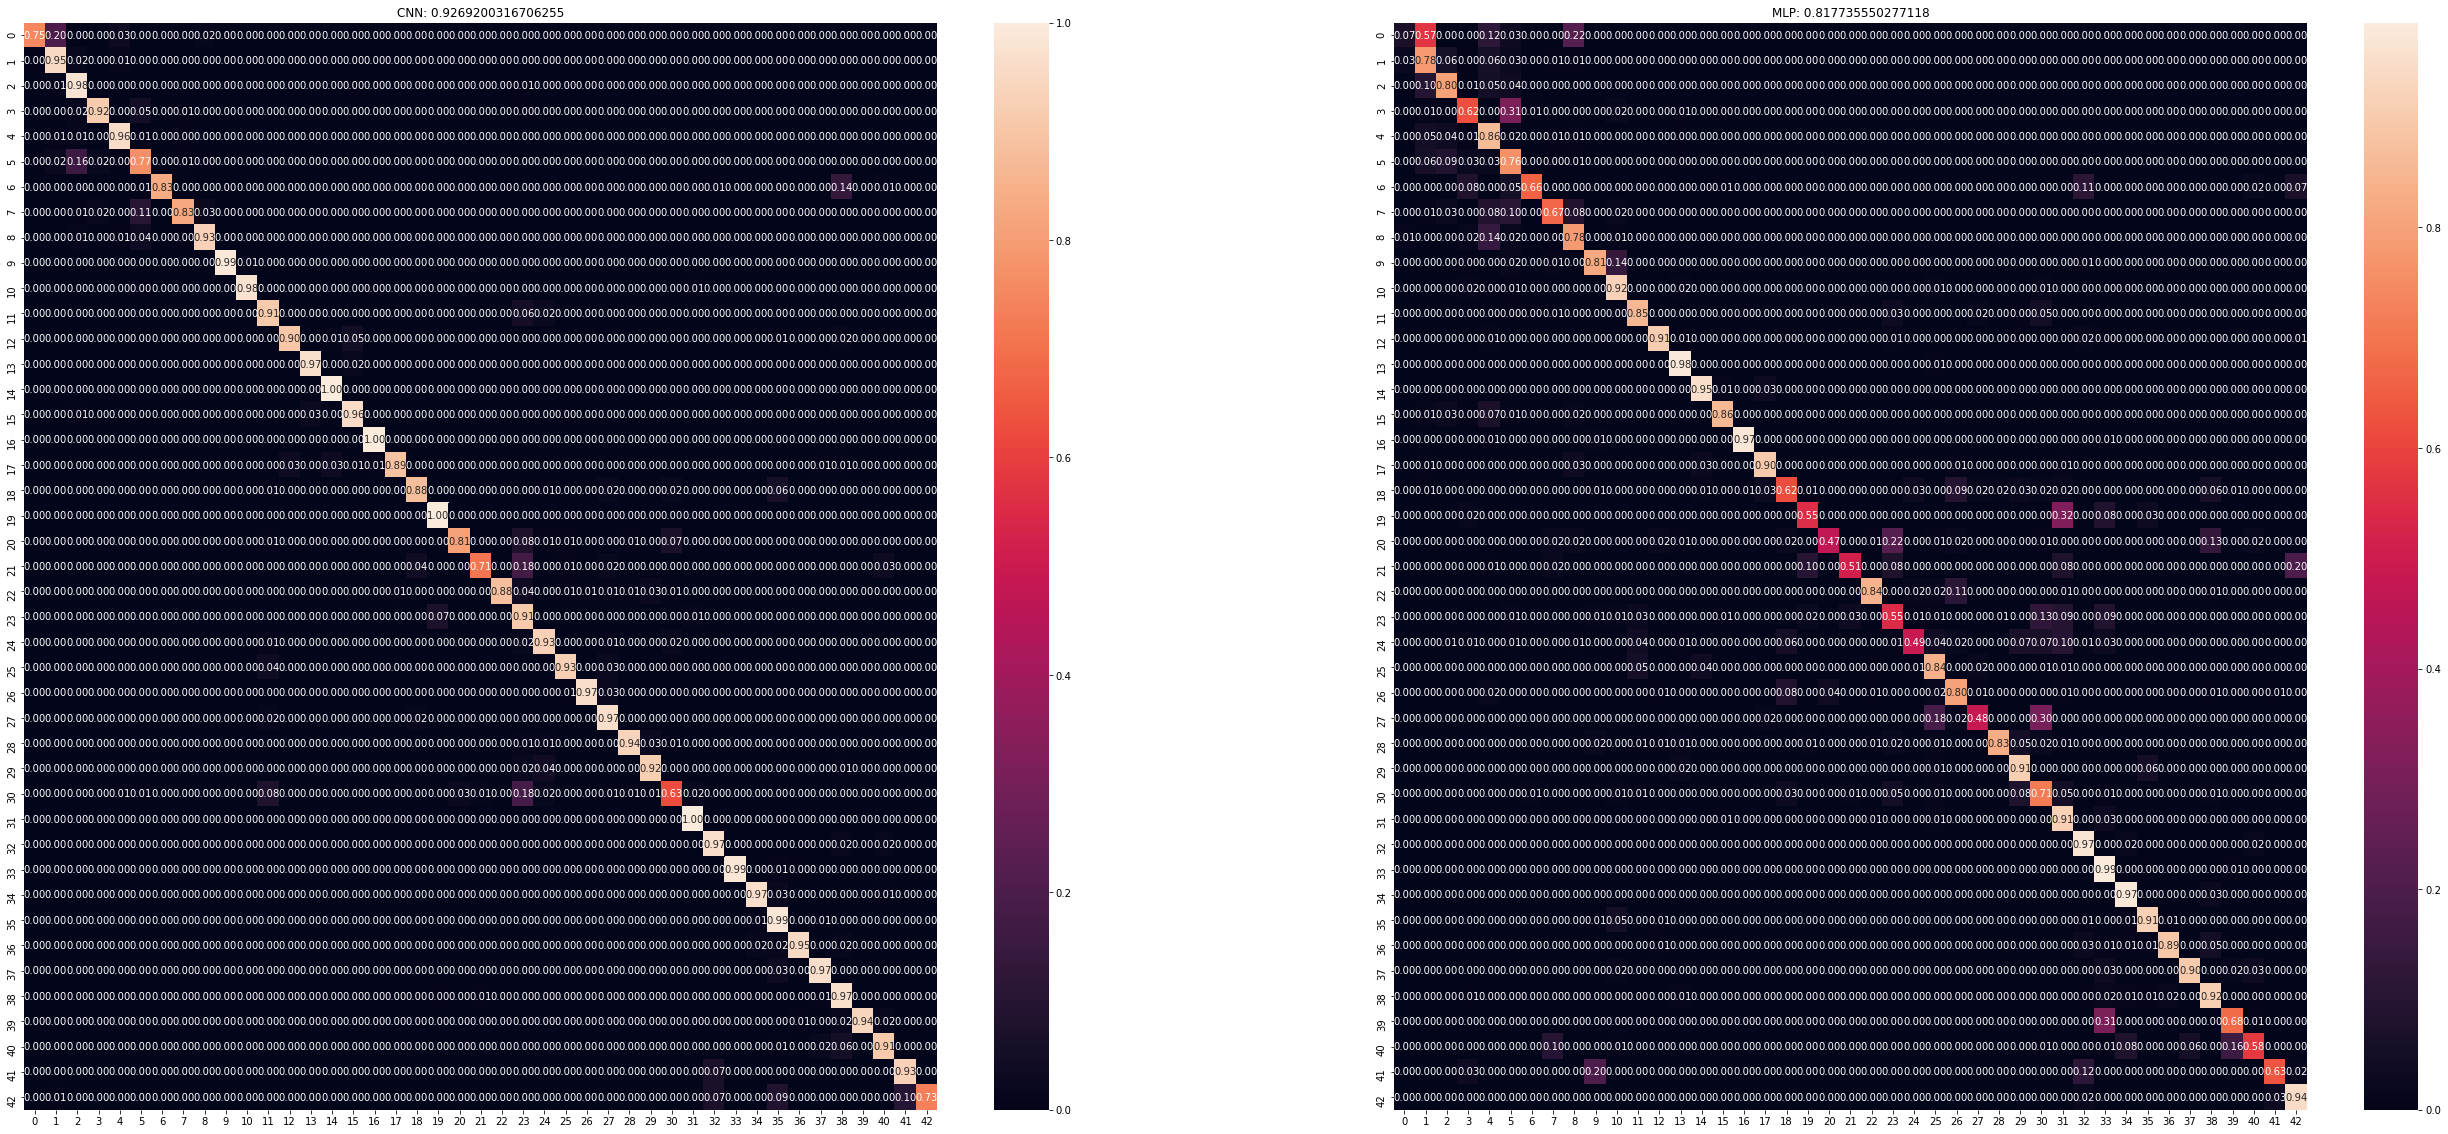

In [66]:
compare_mlp_cnn(cnn2,mlp,X_test_tr,y_test_tr)

In [103]:
data["labels"]
for x in range(len(data["labels"])):
    print("{}: {}".format(x,data["labels"][x]))

0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing for vehicles over 3.5 metric tons
11: Right-of-way at the next intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles over 3.5 metric tons prohibited
17: No entry
18: General caution
19: Dangerous curve to the left
20: Dangerous curve to the right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End of all speed and passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout mandatory
41: End of no passing
42: End of no passing by vehic

For the comparision between the MLP and our best CNN (CNN2), we see that the MLP had issues with several groups of classes like 18-21 which dealt with signs about upcoming curves or general caution. We do not see this issue in the CNN and the CNN greatly outperformed the MLP by over 10%.